Nasdaq Cleaning

In [3]:
import pandas as pd
import numpy as np
import sys
import os

os.chdir("/Users/zhengxuanzhao/vs code/stock/data/source/")

In [4]:
nas = pd.read_csv("nasdaq_2022-06_2025-06.csv",index_col=False)

nas.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC
1,Date,NaN,NaN,NaN,NaN,NaN
2,2022-06-23,11232.1904296875,11260.26953125,11046.2802734375,11137.6796875,5258200000
3,2022-06-24,11607.6201171875,11613.23046875,11337.7802734375,11351.3095703125,9468130000
4,2022-06-27,11524.5498046875,11677.490234375,11487.0703125,11661.01953125,5047860000


In [5]:
nas = nas.iloc[2:,:]

nas = nas.astype({"Close":float, "High":float, "Low":float, 
                         "Open":float, "Volume":float})

nas.head()

,Price,Close,High,Low,Open,Volume
2,2022-06-23,11232.190430,11260.269531,11046.280273,11137.679688,5.258200e+09
3,2022-06-24,11607.620117,11613.230469,11337.780273,11351.309570,9.468130e+09
4,2022-06-27,11524.549805,11677.490234,11487.070312,11661.019531,5.047860e+09
5,2022-06-28,11181.540039,11635.849609,11177.679688,11542.240234,5.433220e+09
6,2022-06-29,11177.889648,11226.330078,11072.190430,11160.219727,5.650860e+09


In [6]:
nas["p_change"] = (nas["Open"] - nas["Close"])/nas["Open"]

nas['Prev Close'] = nas['Close'].shift(1).fillna(nas['Open'])
# calculate average true range

def cal_atr(r):
    return max(
        r['High'] - r['Low'],
        abs(r['High'] - r['Prev Close']) if pd.notnull(r['Prev Close']) else 0,
        abs(r['Low'] - r['Prev Close']) if pd.notnull(r['Prev Close']) else 0
    ) 

nas["TR"] = nas.apply(lambda x : cal_atr(x), axis=1)
nas["atr14"] = nas["TR"].rolling(window=14).mean()
nas["atr21"] = nas["TR"].rolling(window=21).mean()

nas.head()

,Price,Close,High,Low,Open,Volume,p_change,Prev Close,TR,atr14,atr21
2,2022-06-23,11232.190430,11260.269531,11046.280273,11137.679688,5.258200e+09,-0.008486,11137.679688,213.989258,NaN,NaN
3,2022-06-24,11607.620117,11613.230469,11337.780273,11351.309570,9.468130e+09,-0.022580,11232.190430,381.040039,NaN,NaN
4,2022-06-27,11524.549805,11677.490234,11487.070312,11661.019531,5.047860e+09,0.011703,11607.620117,190.419922,NaN,NaN
5,2022-06-28,11181.540039,11635.849609,11177.679688,11542.240234,5.433220e+09,0.031250,11524.549805,458.169922,NaN,NaN
6,2022-06-29,11177.889648,11226.330078,11072.190430,11160.219727,5.650860e+09,-0.001583,11181.540039,154.139648,NaN,NaN


In [7]:
nas["pct_change"] = nas["Close"].pct_change()

def score_change(pct):
    if pct > 0.02:
        return 5
    elif pct > 0.01:
        return 4
    elif pct > -0.005:
        return 3
    elif pct > -0.02:
        return 2
    else:
        return 1

nas["p_score"] = nas["pct_change"].apply(score_change)

In [8]:
## MA

nas["MA5"] = nas["Close"].rolling(5).mean()
nas["MA20"] = nas["Close"].rolling(20).mean()

nas["ma5_score"] = (nas["Close"] > nas["MA5"]).astype(int)
nas["ma20_score"] = (nas["Close"] > nas["MA20"]).astype(int)

In [9]:
# RSI

import ta

nas["rsi"] = ta.momentum.RSIIndicator(nas["Close"]).rsi()

def score_rsi(r):
    if pd.isna(r):
        return 0
    elif r > 70:
        return 2
    elif r < 30:
        return -2
    else:
        return 0

nas["rsi_score"] = nas["rsi"].apply(score_rsi)

In [10]:
# volume 5 days average

nas["vol_avg5"] = nas["Volume"].rolling(5).mean()
nas["vol_avg5_score"] = (nas["Volume"] > nas["vol_avg5"]).astype(int)

In [11]:
# Z - score

from scipy.stats import zscore

nas["z_score"] = zscore(nas["pct_change"].fillna(0))

def zscore_to_score(z):
    if z > 2:
        return 5
    elif z > 1:
        return 4
    elif z > -1:
        return 3
    elif z > -2:
        return 2
    else:
        return 1

nas["z_score_score"] = nas["z_score"].apply(zscore_to_score)

In [12]:
weights = {
    "p_score": 0.3,
    "ma5_score": 0.1,
    "ma20_score": 0.1,
    "vol_avg5_score": 0.1,
    "rsi_score": 0.2,
    "z_score_score": 0.2
}

In [13]:
nas["score"] = (
    nas["p_score"] * weights["p_score"] +
    nas["ma5_score"] * weights["ma5_score"] +
    nas["ma20_score"] * weights["ma20_score"] +
    nas["vol_avg5_score"] * weights["vol_avg5_score"] +
    nas["rsi_score"] * weights["rsi_score"] +
    nas["z_score_score"] * weights["z_score_score"]
)


In [14]:
min_score = nas["score"].min()
max_score = nas["score"].max()

nas["score_final"] = ((nas["score"] - min_score) / (max_score - min_score)) * 100

In [19]:
nas.rename(columns={"Price":"Period"},inplace=True)

nas.head(5)

,Period,Close,High,Low,Open,Volume,p_change,Prev Close,TR,atr14,...,ma5_score,ma20_score,rsi,rsi_score,vol_avg5,vol_avg5_score,z_score,z_score_score,score,score_final
2,2022-06-23,11232.190430,11260.269531,11046.280273,11137.679688,5.258200e+09,-0.008486,11137.679688,213.989258,NaN,...,0,0,NaN,0,NaN,0,-0.058082,3,0.9,23.333333
3,2022-06-24,11607.620117,11613.230469,11337.780273,11351.309570,9.468130e+09,-0.022580,11232.190430,381.040039,NaN,...,0,0,NaN,0,NaN,0,2.270718,5,2.5,76.666667
4,2022-06-27,11524.549805,11677.490234,11487.070312,11661.019531,5.047860e+09,0.011703,11607.620117,190.419922,NaN,...,0,0,NaN,0,NaN,0,-0.556703,3,1.2,33.333333
5,2022-06-28,11181.540039,11635.849609,11177.679688,11542.240234,5.433220e+09,0.031250,11524.549805,458.169922,NaN,...,0,0,NaN,0,NaN,0,-2.131804,1,0.5,10.000000
6,2022-06-29,11177.889648,11226.330078,11072.190430,11160.219727,5.650860e+09,-0.001583,11181.540039,154.139648,NaN,...,0,0,NaN,0,6.171654e+09,0,-0.080828,3,1.5,43.333333


In [20]:
nas.to_csv("cleaned_nas_2022-06_2025-06.csv")

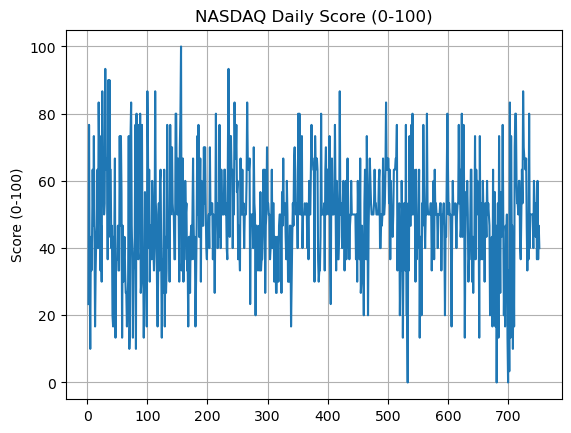

In [21]:
import matplotlib.pyplot as plt

nas["score_final"].plot(title="NASDAQ Daily Score (0-100)")
plt.ylabel("Score (0-100)")
plt.grid(True)
plt.show()